In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white", palette="crest")

## Análise dos dados de psicanalistas no Rio de Janeiro
### Dados extraídos do Doctoralia

Dentre todas as colunas capturadas no perfil do Doctoralia, foi feito um tratamento inicial para manter somente as informações que eram mais relevantes. Com isso, mantiveram-se as seguintes colunas para a realização da análise.

| Colunas | Informação |
| --- | --- |
| psicanalista | Nome do profissional |
| link | Link da página do profissional com mais detalhes |
| reviews | Quantidade de opiniões recebidas |
| stars | Avaliação média de 1 a 5 |
| spec | Principais especialidades do profissional |
| name_service | Tipo de serviço prestado |
| price | Preço cadastrado na plataforma |
| convenio | Se atende ou não por convênio |
| attend_adult | Se atende adulto ou não|
| attend_child | Se atende ou não criança/adolescente |
| service_age | A partir de que idade o profissional atende |
| num_page | Em que página o perfil apareceu |

**Os dados foram extraídos no dia 06/09/2023.

Em termos de tratamento dos dados, foram realizadas algumas etapas para obter informações relevantes:

* **Extração de informações do link**: Aplicando regex, foi possível extrair a partir do link do `Google Maps` a informação de latitude e longitude. Assim como, foi possível obter o id de cada psicanalista na plataforma. 

* **Dados de bairro**: Nem todos eram corretamente cadastrados, então foi realizado o tratamento utilizando a biblioteca `GeoPy` com o módulo `Nominatim`.

* **Serviços filtrados**: Alguns serviços fugiam ao escopo de Psicanálise e ao objetivo esperado, logo foram descartados.

* **Dados booleanos**: Para extrair as informações de plano e atendimento por idade, foi preciso converter as colunas para o formato booleano, a partir do texto. 

In [2]:
#carregamento da base de dados
psi_profile = pd.read_excel('data/20230905_full_db_psicalistas.xlsx').replace({'bairro':{'Recreio dos Bandeirantes':'Recreio'}})
psi_profile = psi_profile[['psicanalista','reviews','stars','spec','bairro','name_service',
                          'price','convenio','attend_adult','attend_child','service_age', 'num_page']].drop_duplicates(
                              ['psicanalista','bairro','name_service','price']
                          )

In [3]:
psi_profile.head()

,psicanalista,reviews,stars,spec,bairro,name_service,price,convenio,attend_adult,attend_child,service_age,num_page
0,Prof. Ligia Cristina Meira,141.0,5.0,"Psicanalista, Psicólogo, Terapeuta complementar",Copacabana,NaN,NaN,0.0,1.0,0.0,18.0,1
1,Dr. Jose Romulo Frota,32.0,5.0,"Psicanalista, Sexólogo",Humaitá,Consulta Psicanálise,250.0,1.0,1.0,0.0,18.0,1
2,Letícia Fernandes Oliveira,73.0,5.0,"Psicanalista, Psicóloga",Ipanema,Teleconsulta,NaN,0.0,1.0,1.0,11.0,1
3,Dr. Mauricio Gadbem,250.0,5.0,"Psicanalista, Psiquiatra",Centro,NaN,NaN,NaN,NaN,NaN,NaN,1
4,Dra. Clarissa Merian,21.0,5.0,"Psicanalista, Psicóloga",Copacabana,Primeira consulta psicanálise,250.0,1.0,1.0,1.0,12.0,1


In [4]:
psi_profile.info()

<class 'pandas.core.frame.DataFrame'>
Index: 687 entries, 0 to 906
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   psicanalista  687 non-null    object 
 1   reviews       286 non-null    float64
 2   stars         286 non-null    float64
 3   spec          687 non-null    object 
 4   bairro        687 non-null    object 
 5   name_service  202 non-null    object 
 6   price         147 non-null    float64
 7   convenio      301 non-null    float64
 8   attend_adult  673 non-null    float64
 9   attend_child  673 non-null    float64
 10  service_age   178 non-null    float64
 11  num_page      687 non-null    int64  
dtypes: float64(7), int64(1), object(4)
memory usage: 69.8+ KB


#### Quantidade de psicanalista por bairro

Foi feito inicialmente um entendimento de quantos profissionais estão cadastrados por bairro, excluindo todo mundo que não tenha o dado de localidade. Isso pode ocorrer para perfis incompletos.

- É possível perceber que os bairros do Centro, Botafogo, Copacabana e Barra da Tijuca se destacam.
- A base inteira mostra uma variedade grande de bairros da cidade.

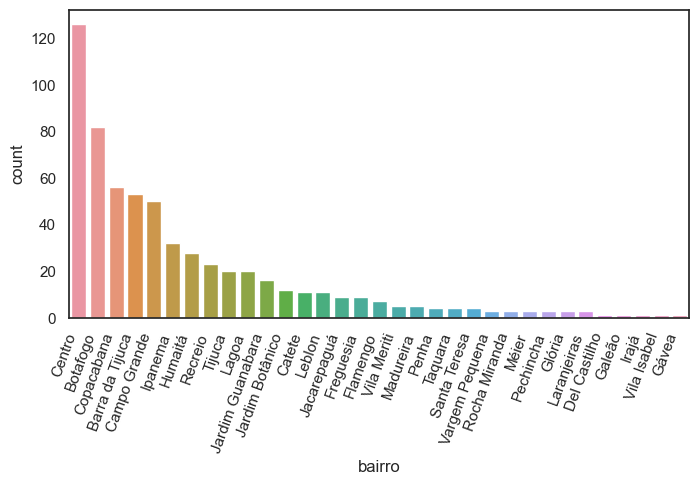

In [6]:
num_psi = psi_profile.drop_duplicates('psicanalista').dropna(subset=['bairro'], axis=0).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8,4))
sns.countplot(data=num_psi, x='bairro', order=num_psi.groupby('bairro')['psicanalista'].count().sort_values(ascending=False).index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
plt.show()

### Distribuição dos preços das sessões

Olhando para a distribuição dos preços, excluindo alguns valores na faixa de 600 reais, a maior parte se concentra no intervalo até 400 reais, com média na faixa dos 176 reais e mediana de 160 reais.

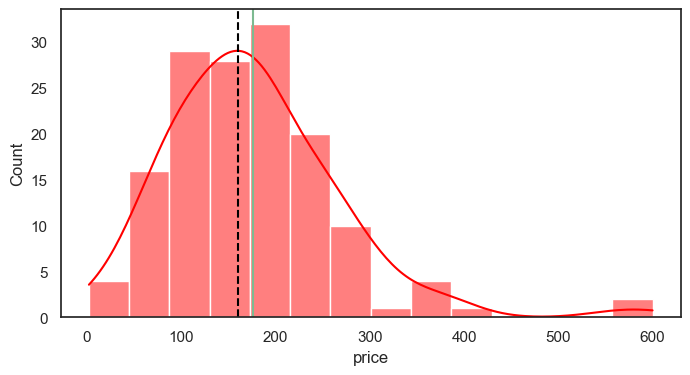

In [7]:
avg_price = psi_profile.dropna(subset=['price'], axis=0).groupby(['psicanalista','bairro']).agg(
    price = ('price', 'mean'),
    reviews = ('reviews', 'max'),
    stars = ('stars', 'max')
).reset_index().dropna(subset=['price'], axis=0).fillna(0)

fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(data=avg_price, x='price', kde=True, color='red')
ax.axvline(x=avg_price.price.mean())
ax.axvline(avg_price['price'].median(), linestyle='dashed', color='black')
plt.show()

### Média dos preços por bairro

Como a variação entre a média e a mediana são baixas, pois não há muita discrepância nos valores, foi adotada a métrica da média para avaliar a situação por bairro.

Considerando que muitos bairro tem poucos profissionais, foi feita uma limpeza para realizar o cálculo só com mais de 3 profissionais. Mesmo assim, podem haver discrepâncias nos valores frente a outras localidades, dada a baixa amostragem.

Dito isso, destacam-se Jacarepaguá, Barra da Tijuca, Recreio, Leblon e Freguesia (todos acima da média).
- Entende-se por Jacarepaguá como a região na proximidade do Parque Olímpico.
- Exceto pela Barra da Tijuca, todos os demais tem poucos representantes com preço cadastrado.

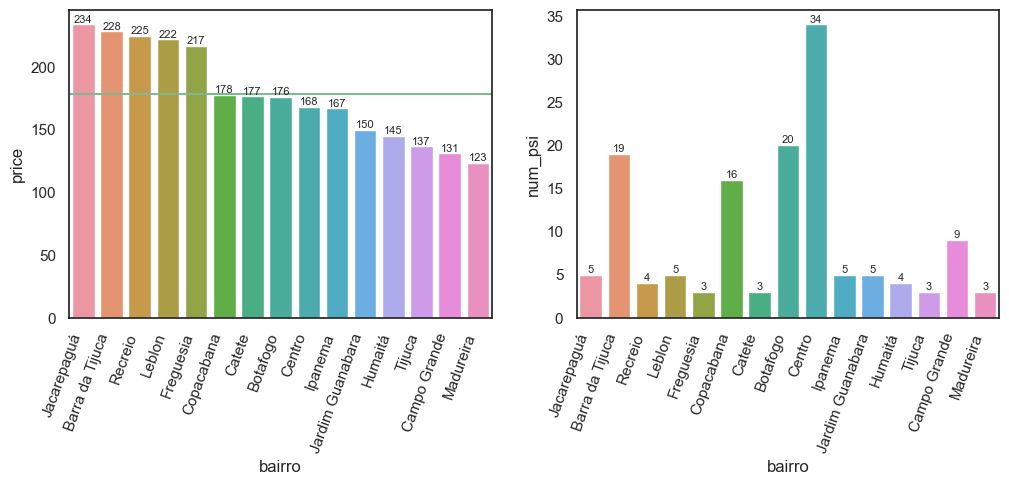

In [8]:
avg_price_bairro = psi_profile.dropna(subset=['price'], axis=0).groupby('bairro').agg(
    price = ('price', 'mean'),
    reviews = ('reviews', 'mean'),
    stars = ('stars', 'mean'),
    num_psi = ('psicanalista', 'count')
).reset_index().fillna(0).sort_values('price', ascending=False)

avg_price_bairro = avg_price_bairro[avg_price_bairro['num_psi']>2].reset_index()

fig, ax = plt.subplots(figsize=(12,4), ncols=2, nrows=1)
sns.barplot(data=avg_price_bairro, x='bairro', y='price', ax=ax[0])
ax[0].axhline(y=avg_price_bairro.price.mean())
sns.barplot(data=avg_price_bairro, x='bairro', y='num_psi', ax=ax[1])
for axs in ax:
    axs.set_xticklabels(axs.get_xticklabels(), rotation=70, ha='right')
    axs.bar_label(axs.containers[0], label_type='edge', fontsize=8, fmt='{:.0f}')

plt.show()

### Média em Botafogo

Um dos pontos de interesse era avaliar a média dos preços dos profissionais no bairro de Botafogo.

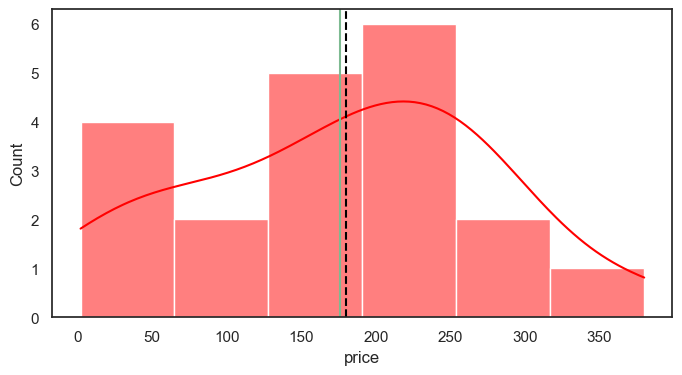

In [9]:
avg_price_botafogo = avg_price[avg_price['bairro']=='Botafogo'].reset_index()

fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(data=avg_price_botafogo, x='price', kde=True, color='red')
ax.axvline(x=avg_price_botafogo.price.mean())
ax.axvline(avg_price_botafogo['price'].median(), linestyle='dashed', color='black')
plt.show()

### Quantidade que atende com plano

Considerando a variável dos planos de saúde, a maior parte dos profissionais optam por não ofertar essa possibilidade e a variação geral de preços não é grande entre um e outro, exceto que a média dos profissionais que aceitam plano costumam cobrar mais.

<Axes: xlabel='convenio', ylabel='price'>

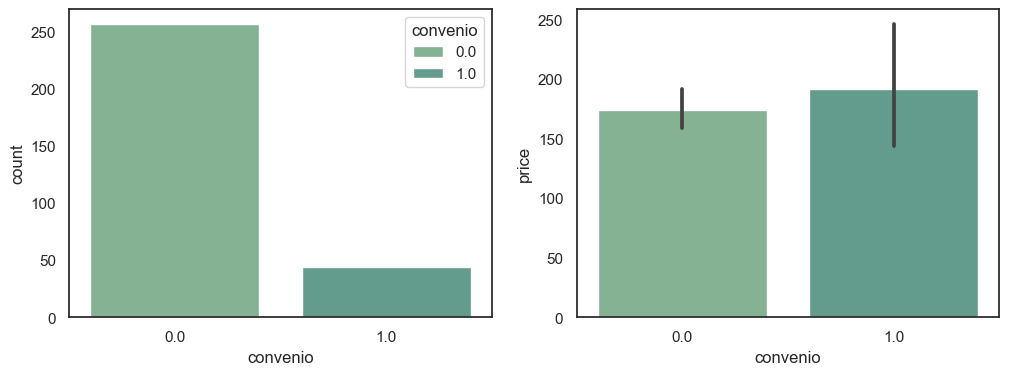

In [10]:
insurance_price = psi_profile.dropna(subset='convenio', axis=0).drop_duplicates('psicanalista')

fig, ax = plt.subplots(1,2,figsize=(12,4))
sns.countplot(data=insurance_price, x='convenio', hue='convenio', dodge=False, ax=ax[0])
sns.barplot(data=insurance_price, x='convenio', y='price', ax=ax[1])

### Analisando a distribuição das idades e perfis de atendimento

* Considerando o perfil de atender adultos, 98% dos profissionais atendem para esse público, logo, poucos são focados exclusivamente para crianças.
* Quanto a crianças, 37% dos profissionais atendem de forma mais abrangente em relação às faixas etárias.


    > Quando se fala em criança, foi feita uma divisão para entender do que se trata essa faixa de idade. 
    >
    >28% dos profissionais atendem em qualquer faixa etária (quando foi cadastrado até 2 anos de idade). 
    >
    > 25% atendem crianças a partir de 3 anos, 10% atendem adolescentes a partir de 12 anos.

* Por fim, não houve uma variação significativa na média dos preços aplicados entre os profissionais que atendem em diferentes faixas etárias.

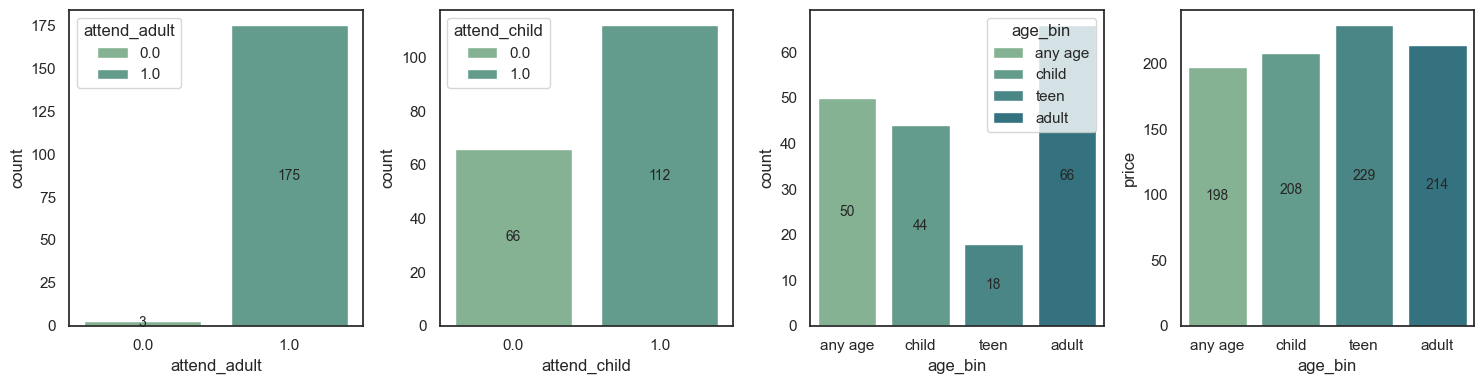

In [23]:
avg_age_price = psi_profile[~((psi_profile['attend_adult']==0)&(psi_profile['attend_child']==0))].drop_duplicates('psicanalista')\
                                                                                                .reset_index(drop=True)
avg_age_price['age_bin'] = pd.cut(avg_age_price['service_age'], bins=[-1,2,12,17,18], labels=['any age', 'child','teen','adult'])

fig, ax = plt.subplots(1,4,figsize=(15,4))
sns.countplot(data=avg_age_price, x='attend_adult', hue='attend_adult', dodge=False, ax=ax[0])
sns.countplot(data=avg_age_price, x='attend_child', hue='attend_child', dodge=False, ax=ax[1])
sns.countplot(data=avg_age_price, x='age_bin', hue='age_bin', dodge=False, ax=ax[2])
sns.barplot(data=avg_age_price, x='age_bin', y='price', ax=ax[3], errorbar=None)
for axs in ax:
    try:
        for container in axs.containers:
            labels = [f'{v:.0f}' if v > 0 else "" for v in container.datavalues]   
            axs.bar_label(container, labels=labels, label_type='center', fontsize=10)
    except:
        continue
plt.tight_layout()
plt.show()

### Distribuição dos dados entre as opiniões obtidas e os preços praticados

Entendendo que o bairro influencia o preço praticado, as faixas etárias e o plano de saúde não são significativos para mudar o preço praticado, a última comparação ocorre entre a quantidade de avaliações na plataforma e o preço.

Inicialmente foi feita a análise considerando preço e reviews diretamente. Como as escalas ficaram muito diferentes, foi feita uma adaptação de log-log para ambos os eixos, aproximando para o valor percentual em ambas as escalas.

Feita essa aproximação é possível perceber um crescimento do percentual de reviews influenciando positivamente nos preços. Apesar disso, a correlação entre as variáveis é baixa (~0,3).

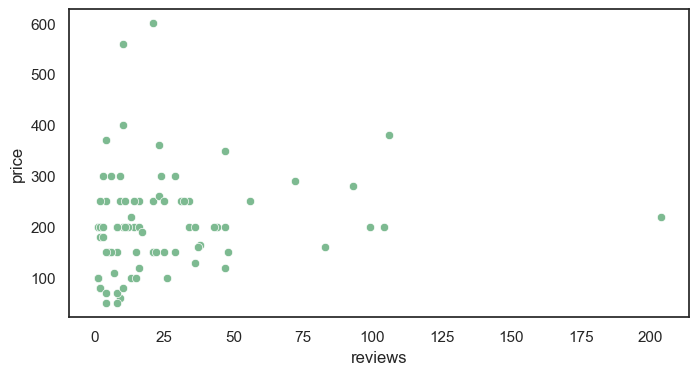

In [24]:
price_review = avg_price[avg_price['reviews']>0].reset_index(drop=True).drop('stars', axis=1)
price_review['log_price'] = price_review['price'].apply(np.log)
price_review['log_reviews'] = price_review['reviews'].apply(np.log)

fig, ax = plt.subplots(figsize=(8,4))
sns.scatterplot(data=price_review, x='reviews', y='price')
plt.show()

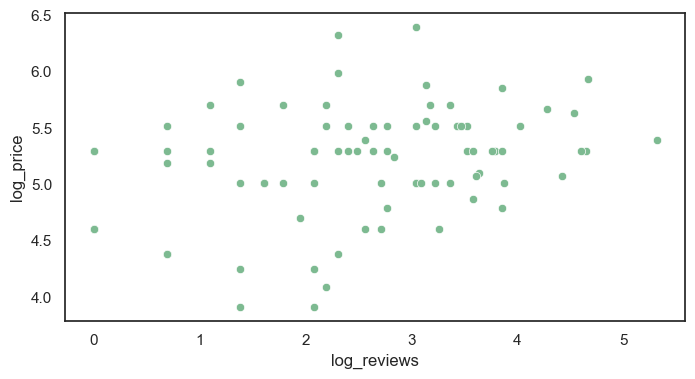

In [25]:
fig, ax = plt.subplots(figsize=(8,4))
sns.scatterplot(data=price_review, x='log_reviews', y='log_price')
plt.show()

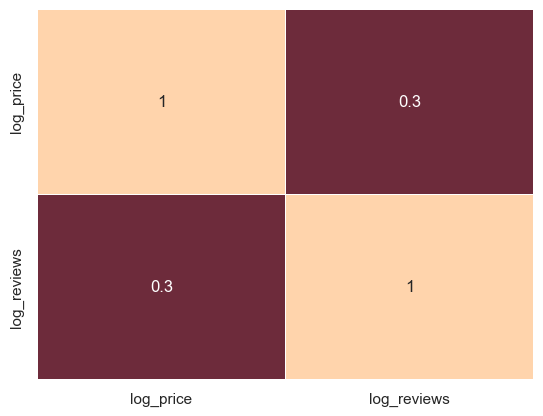

In [197]:
sns.heatmap(price_review.iloc[:,3:].corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False)
plt.show()

### Conclusão

A partir dessa análise preliminar, é possível dizer que o **bairro** é o fator que mais afeta o preço praticado pelos profissionais na plataforma. A questão do review dar um indicativo positivo, seria necessário explorar mais, pois esse pode ser um fator que se explica por outras razões e levem a um aumento de preço, p.ex., profissionais com muito tempo de experiência e já tem uma base consolidada de pacientes.

Ainda há outras oportunidades de se analisar, ampliando o escopo para além de psicanalistas, olhar outras localidades próximas ao Rio de Janeiro, coletar o tempo de experiência e outras variáveis que deem mais destaque ao profissional. Por fim, o que está escrito em cada avaliação pode ter um peso representativo ainda a ser mapeado.